In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import glob
import time
import cv2
import time
import numpy as mp
%matplotlib inline

In [27]:
car_images = glob.glob('vehicles/vehicles/**/*.png')
noncar_images = glob.glob('non-vehicles/non-vehicles/**/*.png')

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm='L2',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm='L2',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


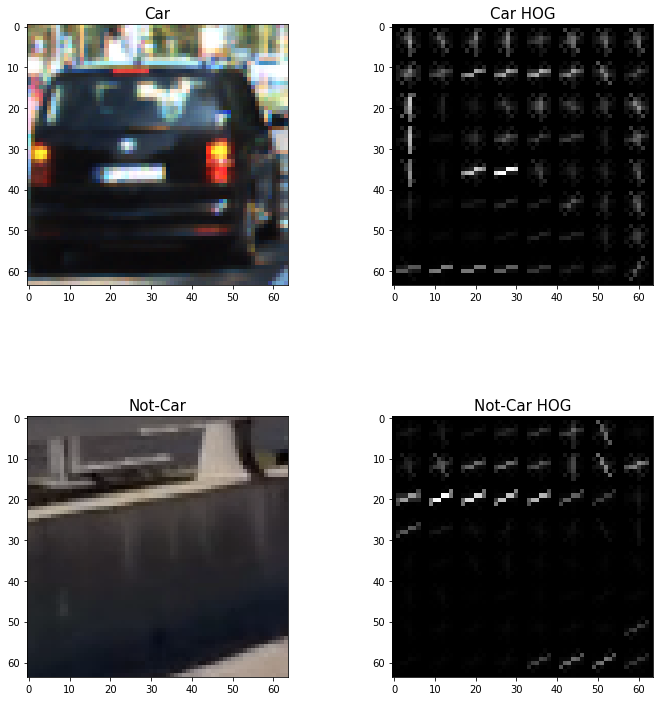

In [41]:
car_img = mpimg.imread(car_images[20])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[20])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
f.subplots_adjust(hspace = .5, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car', fontsize=15)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=15)
ax3.imshow(noncar_img)
ax3.set_title('Not-Car', fontsize=15)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Not-Car HOG', fontsize=15)

In [42]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



In [43]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 16
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

cars = car_images
notcars = noncar_images

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print(X.shape)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
#X_train = X_scaler.transform(X_train)
#X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


41.83 Seconds to extract HOG features...
(17760, 864)
Using: 8 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 864


# Train a classifier

In [45]:
#Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
#X_train = np.nan_to_num(X_train).reshape(-1,1)
#y_train = np.nan_to_num(y_train).reshape(-1,1)
#X_train = X_train[~np.isnan(X_train)].reshape(-1, 1)
#y_train = y_train[~np.isnan(y_train)].reshape(-1, 1)

svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

2.48 Seconds to train SVC...
Test Accuracy of SVC =  0.9851
My SVC predicts:  [ 0.  1.  1.  1.  0.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  0.  0.  1.  0.  1.]
0.00139 Seconds to predict 10 labels with SVC


In [29]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis= False,feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block,vis= False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block,vis= False, feature_vec=False)
    
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            #test_stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1)
            #test_features = X_scaler.transform(test_stacked)
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(hog_features.reshape(1,-1))
            #test_prediction = svc.predict(test_features)
                
       
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    

    return draw_img, windows

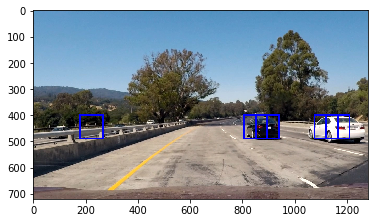

In [48]:
road_img =  mpimg.imread('test_images/test1.jpg')
feature_image = cv2.cvtColor(road_img, cv2.COLOR_RGB2YUV)
ystart = 400
ystop = 530 #656
scale = 1.4
spatial_size=(32, 32)
hist_bins=32

out_img, _ = find_cars(road_img, ystart, ystop, scale, svc, None, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

In [49]:

def draw_windows(test_img, y):
    box_list = []
    for ystart, ystop, s in y:
        test_img, windows = find_cars(test_img, ystart, ystop, s,svc, None, orient, pix_per_cell, cell_per_block,None, None)
        box_list.extend(windows)
    
    return test_img, box_list

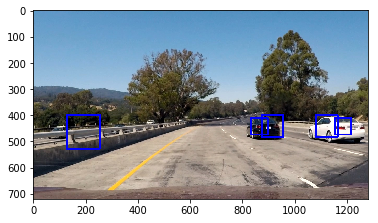

In [50]:
boxes = [(400, 460, 1.0), (410, 480, 1.0), (400, 500, 1.3), (430,530, 1.4), (400, 530, 2.0), (430,560,2.0), (400,600,3.5), (460,660,3.5)]
out_img, box_list = draw_windows(road_img, boxes)
plt.imshow(out_img)


In [51]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


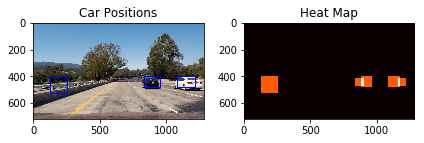

In [52]:
from scipy.ndimage.measurements import label

image = road_img
heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat,box_list)

# Apply threshold to help remove false positives
heat = apply_threshold(heat, 0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

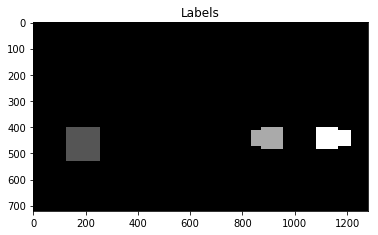

In [53]:
plt.imshow(labels[0], cmap='gray')
plt.title('Labels')

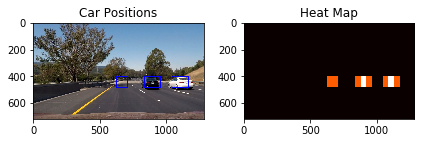

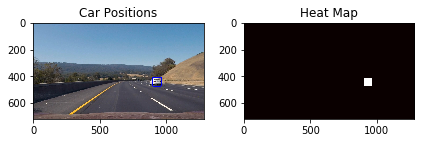

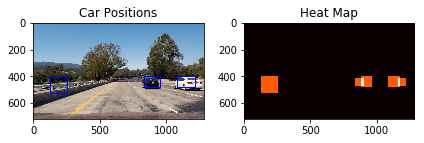

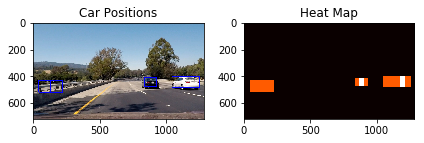

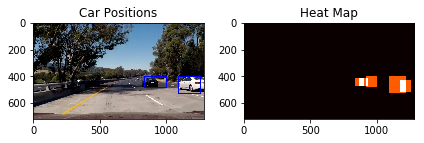

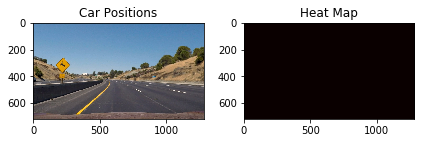

In [57]:
images = glob.glob("test_images/*.jpg")

for img in images:
    image =  mpimg.imread(img)
    boxes = [(400, 460, 1.0), (410, 480, 1.0), (400, 500, 1.3), (430,530, 1.4), (400, 530, 2.0), (430,560,2.0), (400,600,3.5), (460,660,3.5)]
    _, box_list = draw_windows(image, boxes)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 0)

    # Visualize the heatmap when displaying 
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

In [55]:
from collections import deque

history = deque(maxlen = 8)

def vehicle_detection(image):
    boxes = [(400, 460, 1.0), (410, 480, 1.0), (400, 500, 1.3), (430,530, 1.5), (400, 530, 2.0), (430,560,2.0), (400,600,3.5), (460,660,3.5)]
    out_img, box_list = draw_windows(image, boxes)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    heat = apply_threshold(heat,0)
    currheatmap = np.clip(heat, 0, 255)
    history.append(currheatmap)
    heatmap = np.zeros_like(currheatmap).astype(np.float)
    for heat in history:
        heatmap = heatmap + heat

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img
    

In [37]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [38]:
history = deque(maxlen = 8)
output = 'test_result.mp4'
clip = VideoFileClip("test_video.mp4")
video_clip = clip.fl_image(vehicle_detection)
%time video_clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video test_result.mp4
[MoviePy] Writing video test_result.mp4


 97%|█████████▋| 38/39 [00:08<00:00,  4.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_result.mp4 

CPU times: user 13.5 s, sys: 118 ms, total: 13.6 s
Wall time: 8.8 s


In [39]:
history = deque(maxlen = 8)
output = 'project_result.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(vehicle_detection)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


100%|█████████▉| 1260/1261 [04:38<00:00,  4.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result.mp4 

CPU times: user 7min 34s, sys: 4.09 s, total: 7min 38s
Wall time: 4min 39s
